In [1]:
RANDOM_SEED=42

# Common imports.
import os
import sys
import random

os.environ['PYTHONHASHSEED'] = '0'
random.seed(RANDOM_SEED)

import numpy as np
np.random.seed(RANDOM_SEED)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
tf.random.set_seed(RANDOM_SEED)

from tensorflow import keras
from keras import layers

2025-09-03 04:31:14.476487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756873874.754337      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756873874.827150      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Problem Description

Deepfakes are AI-generated or AI-modified images that represent real subjects. As generator models have become increasingly sophisticated, it is almost impossible for humans to determine whether a good deepfake is real or not. Although the use of deepfakes is typically benign, malicious use has become a concern due to the potential for use of deepfakes to mask identities or otherwise trick people into dangerous or costly situations. The United State Deportment of Homeland Security has also expressed concern in this area, and issued a [whitepaper](https://www.dhs.gov/sites/default/files/publications/increasing_threats_of_deepfake_identities_0.pdf) on the subject.

This project aims to use deep learning models to help flag deepfakes in the domain of human faces. A real-world use case could be online identity fraud detection systems that assess submitted photo identification for deepfakes, or fake news detection for online articles that includes images with human faces.

The data we will use for the project is the [StyleGan-StyleGan2 Deepfake Face Images](https://www.kaggle.com/datasets/kshitizbhargava/deepfake-face-images/data) dataset available on Kaggle. It includes ~6k real and ~7k fake images, labeled by directory.

# EDA

We sill start by loading and inspecting the provided data. Since the dataset is provided on Kaggle, we can use [kagglehub](https://pypi.org/project/kagglehub/) to download the dataset. We'll then copy it to our working directory to avoid having a space in the path.

In [2]:
import kagglehub

dataset_path = kagglehub.dataset_download("kshitizbhargava/deepfake-face-images")

print("Path to dataset files:", dataset_path)
!ls {dataset_path}

# Ugh, there's a space in that subdirectory name. Let's move it all to our working area to remove the space
# (unfortunatley, /kaggle/input is read-only)

!mkdir -p /kaggle/working/input
!cp -r {dataset_path}/Final\ Dataset/* /kaggle/working/input

Path to dataset files: /kaggle/input/deepfake-face-images
'Final Dataset'


In [3]:
dataset_path = '/kaggle/working/input'
!ls {dataset_path}

dataset.csv  Fake  Real


## EDA: Image Sizes

Initially, let's take a look at the size distribution of a sample of the images. The dataset description on Kaggle did not provide information about the size(s). We only know that they're JPEGs.

In [4]:
# With help from Google "AI Overview" from prompt "numpy or pandas load images and plot histogram of images sizes"
# and adapted to a function for re-use with different target directories.
import imageio.v3 as iio
import numpy as np
import os

def image_sizes(target_dir):
    '''Returns a list of (width, height) tuples.'''
    sizes=[]
    for filename in os.listdir(target_dir):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            filepath = os.path.join(target_dir, filename)
            try:
                image = iio.imread(filepath)
                height, width = image.shape[:2] # (h, w, c)
                sizes.append((width, height))
            except Exception as e:
                print(f"Could not load {filename}: {e}")
    return sizes

In [5]:
fake_sizes=image_sizes(os.path.join(dataset_path, 'Fake'))
real_sizes=image_sizes(os.path.join(dataset_path, 'Real'))

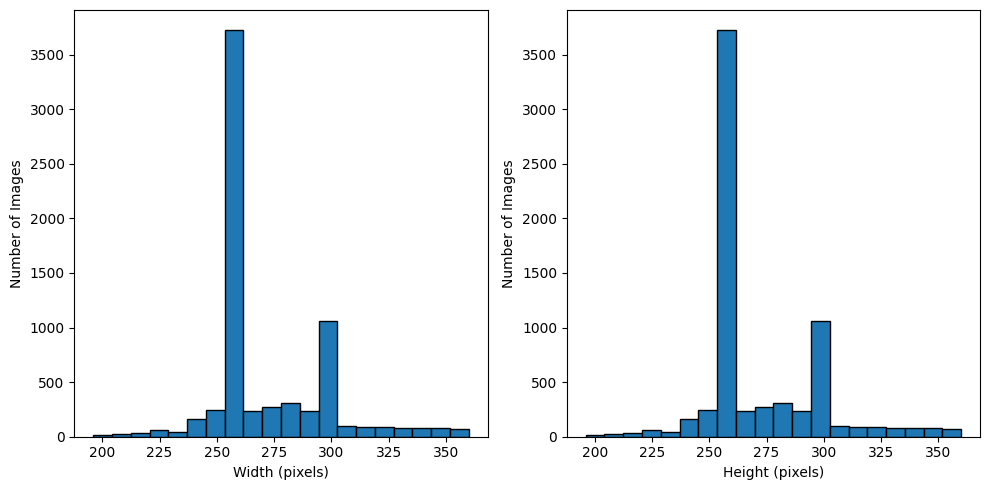

In [6]:
fake_sizes_df = pd.DataFrame(fake_sizes, columns=['Width', 'Height'])

# Plotting histograms:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(fake_sizes_df['Width'], bins=20, edgecolor='black')
plt.xlabel('Width (pixels)')
plt.ylabel('Number of Images')

plt.subplot(1, 2, 2)
plt.hist(fake_sizes_df['Height'], bins=20, edgecolor='black')
plt.xlabel('Height (pixels)')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

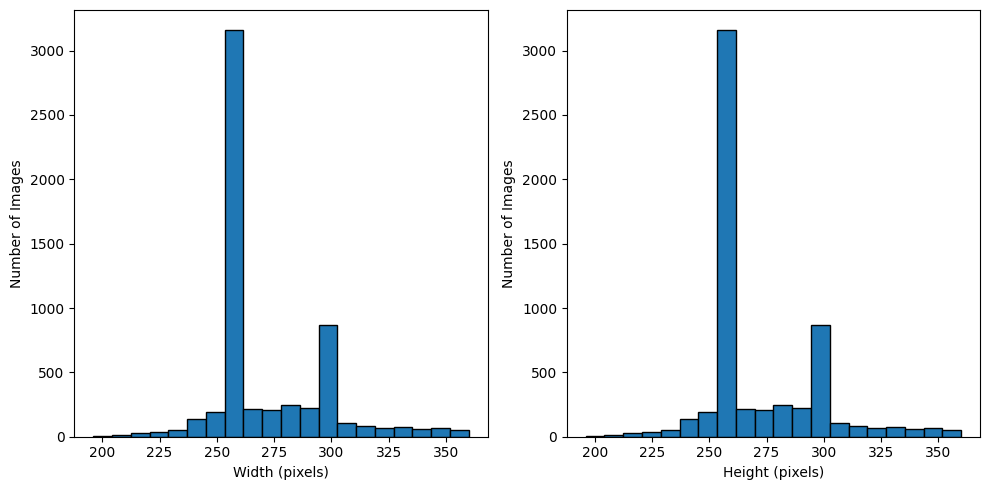

In [7]:
real_sizes_df = pd.DataFrame(real_sizes, columns=['Width', 'Height'])

# Plotting histograms:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(real_sizes_df['Width'], bins=20, edgecolor='black')
plt.xlabel('Width (pixels)')
plt.ylabel('Number of Images')

plt.subplot(1, 2, 2)
plt.hist(real_sizes_df['Height'], bins=20, edgecolor='black')
plt.xlabel('Height (pixels)')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

For both the `Real` and `Fake` images, they're pretty clearly mostly of size 256 x 256. When loading the data into a `Dataset` below, we'll specify that the images are 256x256, which will expanding/shrink those that are not as necssary.

## EDA: Label Distribution

This binary classification problem has two labels: `Fake` and `Real`. To verify that we have a good representation of both fake and real face images, we'll investigate the distribution of our samples.

<Axes: xlabel='Image Type', ylabel='Count'>

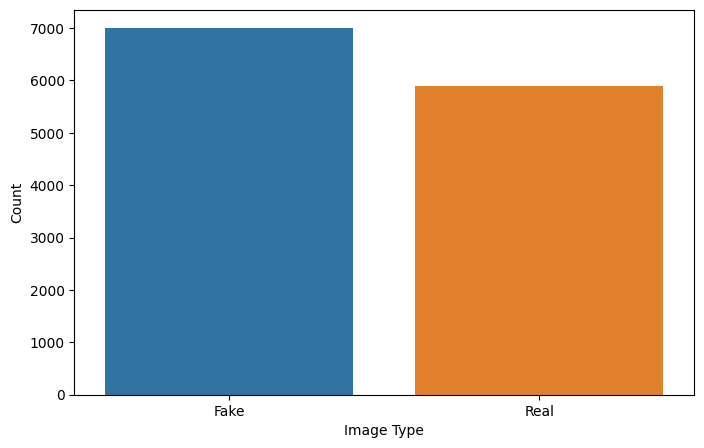

In [8]:
fake_img_files = [f for f in os.scandir(os.path.join(dataset_path, 'Fake'))]
real_img_files = [f for f in os.scandir(os.path.join(dataset_path, 'Real'))]

img_file_counts = pd.DataFrame(
    {
        'Image Type': ['Fake', 'Real'],
        'Count': [len(fake_img_files), len(real_img_files)],
    }
)

plt.figure(figsize=(8, 5))
sns.barplot(x='Image Type', y='Count', data=img_file_counts)

We have a relatively even distribution of samples between `Fake` and `Real` face images, so we don't need to augment or subset either of the categories.

## EDA: Dataset Preparation

We have our training data under `/kaggle/working/input`, which includes subdirectories `Fake` and `Real` corresponding to the labe of the images under each directory.

The dataset can now be loaded into a `Dataset` using the Keras utility [image_dataset_from_directory](https://keras.io/api/data_loading/image/).

We will specify `label_mode="binary"` to associate each subdirectory with an integer/binary label. They are assigned in alphabetical order, so we'll have the following mapping:
* 0: `Fake`
* 1: `Real`

We will also specify `validation_split=0.2` to holdback 20% of the data for validation data to be used during training, which can help provide pressure against overfitting.

In [9]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    label_mode="binary",
    subset="both",
    seed=RANDOM_SEED,
    image_size=(256, 256),
)

Found 12890 files belonging to 2 classes.
Using 10312 files for training.
Using 2578 files for validation.


I0000 00:00:1756874042.162030      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Since the classes were originally labeled based on directory, the dataset creation creates a mapping from the binary value back to string value of the label. It's simply a list that we can index into: 

In [10]:
train_ds.class_names

['Fake', 'Real']

While we're at the loading data stage, we'll create a pseudo-test dataset by extracting a randomized subset of the input data. The `subset="validation"` says to only return the validation set (the 20% in this case), and `shuffle` will randomly shuffle the data. We use a different seed to ensure it's a different subset from `val_ds` above.

In [11]:
test_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    shuffle=True,
    label_mode="binary",
    seed=RANDOM_SEED+99,
    image_size=(256, 256),
)

Found 12890 files belonging to 2 classes.
Using 2578 files for validation.


## EDA: Visualization

With the dataset loaded, we can now sample some of the images to get an overview of what we're working with. Using `train_ds.class_names`, we can label each image with the orignal string value (Real vs. Fake)

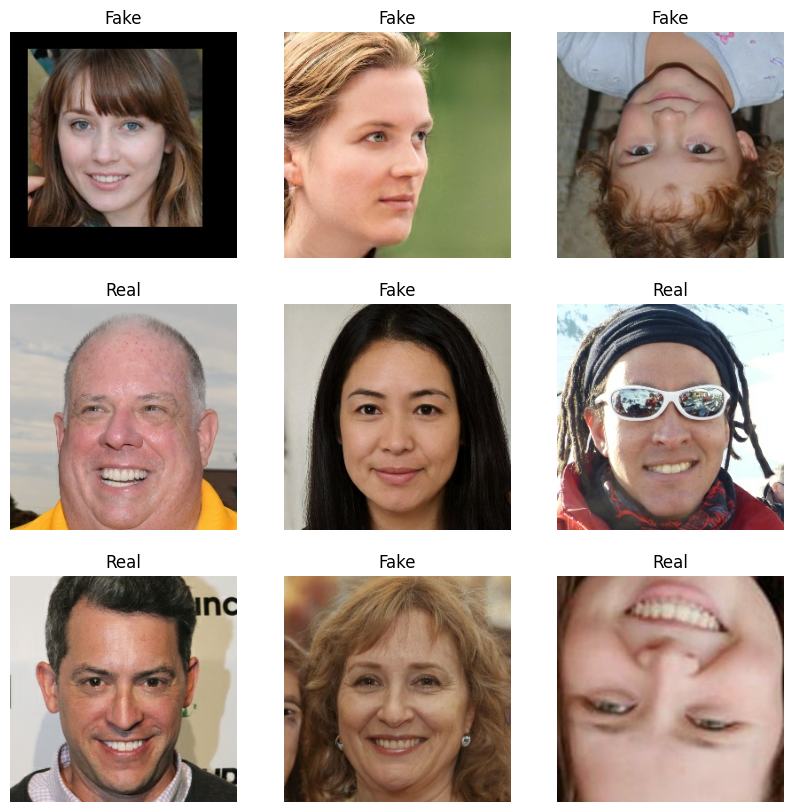

In [12]:
# Adapted from https://keras.io/examples/vision/image_classification_from_scratch/
# to include label names.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(train_ds.class_names[int(labels[i])])
        plt.axis("off")

Observations of note:
* Most of the `Fake` face images look quite real!
* Some flip or rotate data augmentation has already been applied to the data.
* The images are color, so we'll need to normalize the channel values down to [0, 1] as part of preprocessing.



# Modeling

## Modeling: Preprocessing

As noted during EDA, we'll need to scale the color channel values down to between 0 and 1 - we know that networks would have difficulty training on values largely outside of this range and may not converge due to incompatibility with typical activation functions.

To implement scaling preprocessing, we'll add a `Rescaling` layer at the head of the model itself (see below).

Since flip/rotate data augmentation has already been applied to some degree in the provided dataset, we will not apply additional image flip/rotation augmentation.

## Modeling: Architecture (Baseline)

As is typical with image domain ML problems, we'll build a model based on a general CNN (Convolutional Neural Network) architecture. CNNs are good at extracting different features at different levels as convolutions are applied at each "block" level, and our desire for this project is that the network will pick up on small features that, taken together at the fully-connected layers, will be useful for determineing `Fake` vs. `Real` face images.

We will begin with a small CNN that consists of two simple levels of `Conv2D` + `MaxPooling` layers, that latter which is responsible for consolidating the strongest features from the Convolution layer by taking the maximum from each window as it "slides" across the feature output, and downscales the next output shape to keep the size of the network managable.

We will also use `BatchNormalization` within each block to help avoid overfitting to some features that are extracted by the model.

Finally, we will use a `Dropout` layer for regularization before a final `Dense` layer, which is fully connected with all features (inputs) from the convolution layers.

In [13]:

def baseline_cnn_model(input_shape, filter_sizes=[]):
    inputs = layers.Input(input_shape)

    # Rescale to normalize channel values.
    x = layers.Rescaling(1.0/255)(inputs)

    # Add blocks based on the "filter" sizes (as in # filters in Conv2D layer) requested in filter_sizes.
    for f in filter_sizes:
        x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)

    # Finaly Dropout and Dense layers.
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    m = keras.Model(inputs, outputs)
    return m


In [14]:
baseline_cnn = baseline_cnn_model(input_shape=(256,256,3), filter_sizes=[32, 64])

The general architecture is visible below - we feed in the 256x256x3 images, which ultimately result in 262144 inputs to a `Dense` layer for final classification (binary) via the Sigmoid function.

In [15]:
baseline_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       262,145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,481 (1.25 MB)

 Trainable params: 328,097 (1.25 MB)

 Non-trainable params: 384 (1.50 KB)

The model is built, so we can compile it with the desired optimizer and loss function.

`Adam` is the most common optimizer in use for most modest CNN training requirements, and `BinaryCrossentropy` is the common loss function for binary classifiers. We'll start out with a training rate of 0.003 and potentially tune that during Hyperparameter Tuning later on. Training metrics are collected at the end of each epoch for graphing training progress below.

In [16]:
baseline_cnn.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy",
             keras.metrics.AUC(name="auc"),
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall"),
             keras.metrics.F1Score(name="f1_score")]
)

Now we can fit/train the model. Remember that we have a 20% validation set, which will be used via the `validation_data` fit() parameter.

In [17]:
h = baseline_cnn.fit(
    train_ds.prefetch(tf.data.AUTOTUNE),
    epochs=10,
    # epochs=2,
    validation_data=val_ds.prefetch(tf.data.AUTOTUNE),
)

Epoch 1/10


I0000 00:00:1756874051.809830      67 service.cc:148] XLA service 0x78035c001c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756874051.810612      67 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756874052.512574      67 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/323 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.6562 - auc: 0.6145 - f1_score: 0.6596 - loss: 4.2009 - precision: 0.6882 - recall: 0.6683   

I0000 00:00:1756874061.591439      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


323/323 ━━━━━━━━━━━━━━━━━━━━ 47s 100ms/step - accuracy: 0.6277 - auc: 0.6315 - f1_score: 0.6354 - loss: 7.5624 - precision: 0.5909 - recall: 0.5724 - val_accuracy: 0.4566 - val_auc: 0.4831 - val_f1_score: 0.6178 - val_loss: 14.1822 - val_precision: 0.4555 - val_recall: 0.8324
Epoch 2/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - accuracy: 0.6650 - auc: 0.6839 - f1_score: 0.6682 - loss: 6.4843 - precision: 0.6288 - recall: 0.6264 - val_accuracy: 0.4779 - val_auc: 0.5049 - val_f1_score: 0.6379 - val_loss: 24.2344 - val_precision: 0.4717 - val_recall: 0.9759
Epoch 3/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - accuracy: 0.7238 - auc: 0.7485 - f1_score: 0.6975 - loss: 3.9057 - precision: 0.6932 - recall: 0.6987 - val_accuracy: 0.5543 - val_auc: 0.5953 - val_f1_score: 0.6418 - val_loss: 9.2512 - val_precision: 0.5134 - val_recall: 0.8913
Epoch 4/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - accuracy: 0.7742 - auc: 0.8101 - f1_score: 0.7052 - loss: 2.7123 - precision: 0.7482 - recall:

In [18]:
# Modified graphing function from previous project (CNN Cancer Detection)
def graph_train_hist(h):
    # Graph of training/validation loss and accuracy.
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    accuracy = h.history['accuracy']
    val_accuracy = h.history['val_accuracy']
    precision = h.history['precision']
    val_precision = h.history['val_precision']
    recall = h.history['recall']
    val_recall = h.history['val_recall']
    f1_score = h.history['f1_score']
    val_f1_score = h.history['val_f1_score']
    # auc = h.history['auc']
    # val_auc = h.history['val_auc']
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(12, 12))
    
    # Loss
    plt.subplot(3, 2, 1)
    plt.plot(epochs, loss, 'r-', label='Training Loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(3, 2, 2)
    plt.plot(epochs, accuracy, 'r-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Precision
    plt.subplot(3, 2, 3)
    plt.plot(epochs, precision, 'r-', label='Training Precision')
    plt.plot(epochs, val_precision, 'b-', label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(3, 2, 4)
    plt.plot(epochs, recall, 'r-', label='Training Recall')
    plt.plot(epochs, val_recall, 'b-', label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    # F1 Score
    plt.subplot(3, 2, 5)
    plt.plot(epochs, f1_score, 'r-', label='Training F1 Score')
    plt.plot(epochs, val_f1_score, 'b-', label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.show()

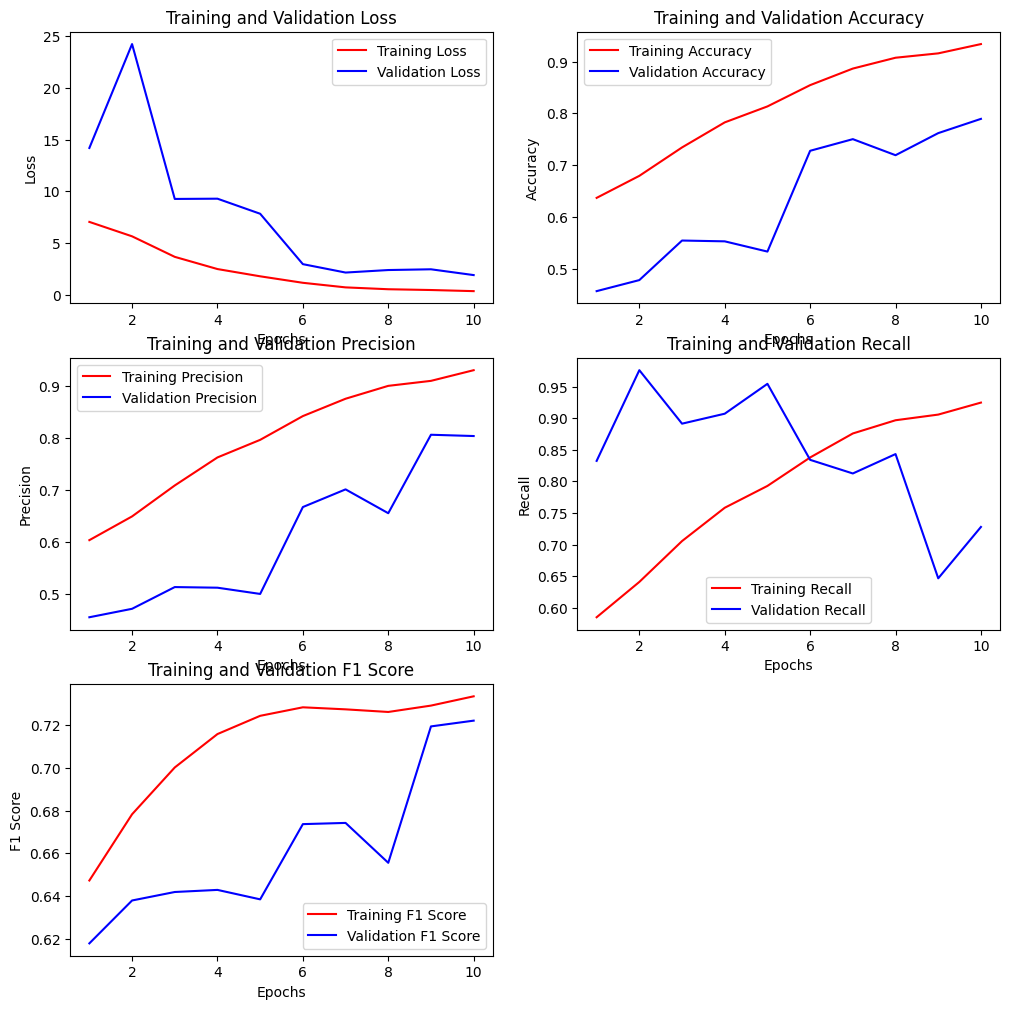

In [19]:
graph_train_hist(h)

In [20]:
# Adapted from Gemini prompt: "plot charts, graphs, and tables to report the results from training a binary classifier"
from sklearn.metrics import classification_report, confusion_matrix

def model_report(model, label):
    class_names=test_ds.class_names
    # Collect test predictions
    y_true = []
    y_prob = []
    for batch_imgs, batch_labels in test_ds:
        probs = model.predict(batch_imgs, verbose=0).ravel()
        y_prob.extend(probs.tolist())
        y_true.extend(batch_labels.numpy().astype(int).tolist())
    
    y_pred = (np.array(y_prob) >= 0.5).astype(int)
    
    print(f"{label} classification report:\n", classification_report(y_true, y_pred, target_names=class_names, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title("Confusion matrix (baseline)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    
    plt.tight_layout()
    plt.show()

Baseline classification report:
               precision    recall  f1-score   support

        Fake     0.9024    0.9401    0.9208      1386
        Real     0.9268    0.8817    0.9037      1192

    accuracy                         0.9131      2578
   macro avg     0.9146    0.9109    0.9123      2578
weighted avg     0.9137    0.9131    0.9129      2578



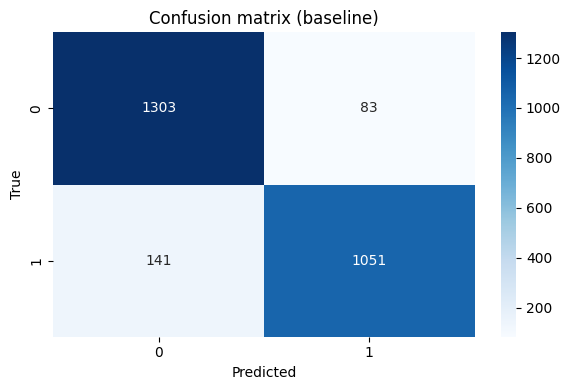

In [21]:
model_report(baseline_cnn, 'Baseline')

<mark>NOTE: Result values in confusion matrices may be different than those referenced in the narrative text.</mark>

**Although we are setting an explicit random seed for all of the libraries in use, the training and inference results will still be nondeterministic due to our use of GPUs.**

For a relatively small model, it performs pretty well.

As far as performance for identifying `Fake` faces, it has a precision of 0.9524, meaning it is correct 95% of the time when predicting a fake (low false-positives). The recall is a bit lower at 0.8225, meaning it missed about 18% of the deepfakes. Overall, the F1-Score for `Fake`s is 0.8827, showing relatively good balance between precision and recall.

Performance for identifying `Real` faces showed precision at 0.8219 and recall at 0.9522 with an F1-Score of 0.8822. As expected, the precsion/recall values roughly mirror the opposite of predicting `Fake`s, however, both values are slightly lower, indicating the performance for identifying `Real` faces is slightly lower.

## Modeling: Architecture (4 Blocks)

We'll now repeat the training and analysis from above for a model with 4 convolution "blocks" instead of 2 to compare raw model size, but following the same general architecture as the baseline and no other hyperparameter tuning.

In [22]:
baseline_cnn_4 = baseline_cnn_model(input_shape=(256,256,3), filter_sizes=[32, 64, 128, 256])

In [23]:
baseline_cnn_4.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 1,241,633 (4.74 MB)

 Trainable params: 1,239,713 (4.73 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [24]:
baseline_cnn_4.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy",
             keras.metrics.AUC(name="auc"),
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall"),
             keras.metrics.F1Score(name="f1_score")]
)

In [25]:
h_4 = baseline_cnn_4.fit(
    train_ds.prefetch(tf.data.AUTOTUNE),
    epochs=10,
    # epochs=2,
    validation_data=val_ds.prefetch(tf.data.AUTOTUNE),
)

Epoch 1/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 59s 131ms/step - accuracy: 0.5859 - auc: 0.6008 - f1_score: 0.6132 - loss: 2.7081 - precision: 0.5403 - recall: 0.5297 - val_accuracy: 0.4791 - val_auc: 0.6072 - val_f1_score: 0.6371 - val_loss: 2.7119 - val_precision: 0.4720 - val_recall: 0.9660
Epoch 2/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 32s 99ms/step - accuracy: 0.6045 - auc: 0.6313 - f1_score: 0.6208 - loss: 2.3499 - precision: 0.5632 - recall: 0.5509 - val_accuracy: 0.6315 - val_auc: 0.6730 - val_f1_score: 0.6366 - val_loss: 2.5444 - val_precision: 0.5974 - val_recall: 0.6490
Epoch 3/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 32s 98ms/step - accuracy: 0.6140 - auc: 0.6513 - f1_score: 0.6183 - loss: 1.9411 - precision: 0.5727 - recall: 0.5626 - val_accuracy: 0.5140 - val_auc: 0.6443 - val_f1_score: 0.6371 - val_loss: 2.2108 - val_precision: 0.4893 - val_recall: 0.9104
Epoch 4/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 32s 98ms/step - accuracy: 0.6445 - auc: 0.6913 - f1_score: 0.6208 - loss: 1.3527 - precision: 0.6053 

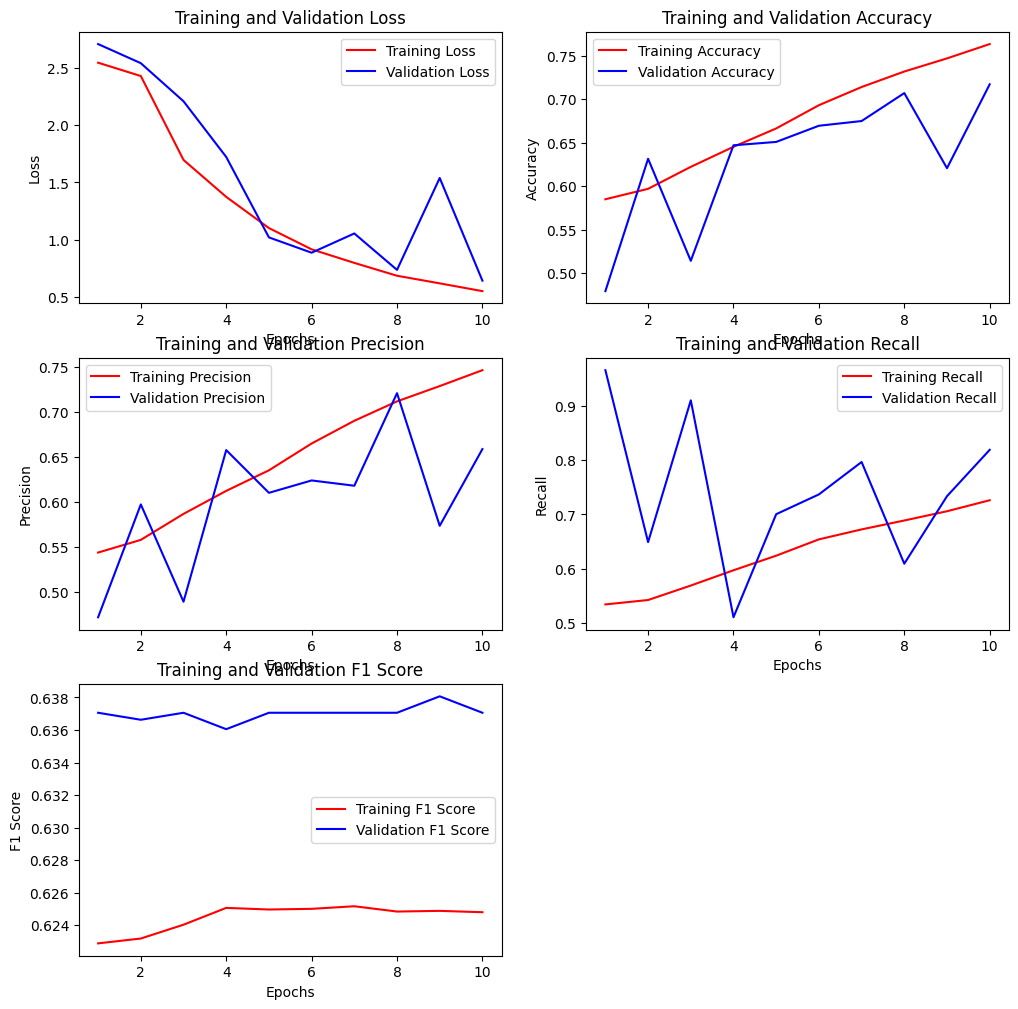

In [26]:
graph_train_hist(h_4)

Baseline (4 Block) classification report:
               precision    recall  f1-score   support

        Fake     0.8394    0.6371    0.7244      1386
        Real     0.6704    0.8582    0.7528      1192

    accuracy                         0.7393      2578
   macro avg     0.7549    0.7477    0.7386      2578
weighted avg     0.7612    0.7393    0.7375      2578



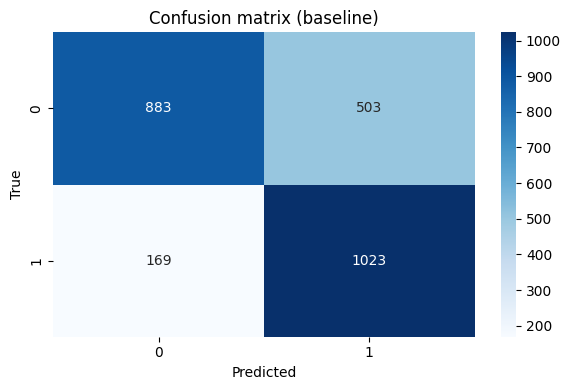

In [27]:
model_report(baseline_cnn_4, 'Baseline (4 Block)')

<mark>NOTE: Result values in confusion matrices may be different than those referenced in the narrative text.</mark>

**Although we are setting an explicit random seed for all of the libraries in use, the training and inference results will still be nondeterministic due to our use of GPUs.**

Overall, we can immediately see that the larger model (4x the number of parameters) performs worse overall. F1-score was down at 0.7116, and recall for `Fake` was quite low at 0.6097.

This gives us a clue that deeper models aren't necessarily better - at least for this problem space and dataset.

## Modeling: Architecture (Hyperparameter Tuning)

With some general baseline performance measured, we'll move on to tuning hyperparameters using the [Keras RandomSearch Tuner](https://keras.io/keras_tuner/api/tuners/random/).

To allow the tuner to provide different hyperparameters, we'll first modify the `baseline_cnn_model` function ot handle different parameters.

Our tunables will consist of:
* `num_blocks`: Choice of 1, 2, 3, 4, or 5 mapping to blocks with filters sized as follows:
   * 1: [32]
   * 2: [32, 64]
   * 3: [32, 64,128]
   * 4: [64, 128]
   * 4: [64, 128, 256]
* `learning_rate`: Choices of 1e-3, 5e-4, or 1e-4
* `use_global_avg_pooling`: Boolean to choose between using `GlobalAveragePooling2D` or `Flatten` for the final layer before fanning out to the final `Dense`.

In [28]:
import keras_tuner as kt

image_input_shape=(256,256,3)
filter_size_choices=[
    [],
    [32],
    [32, 64],
    [32, 64, 128],
    [64, 128],
    [64, 128, 256],
]

def build_cnn_model(hp):
    num_blocks=hp.Choice('num_blocks', values=[1,2,3,4,5])
    filter_sizes=filter_size_choices[num_blocks]
    inputs = layers.Input(image_input_shape)

    # Rescale to normalize channel values.
    x = layers.Rescaling(1.0/255)(inputs)

    # Add blocks based on the "filter" sizes (as in # filters in Conv2D layer) requested in filter_sizes.
    for f in filter_sizes:
        x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)

    # Finaly Dropout and Dense layers.
    x = layers.Dropout(0.2)(x)

    if hp.Boolean('use_global_avg_pooling'):
        x = layers.GlobalAveragePooling2D()(x)
    else:
        x = layers.Flatten()(x)
    
    outputs = layers.Dense(1, activation="sigmoid")(x)

    m = keras.Model(inputs, outputs)
    
    m.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
        ),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=["accuracy",
                 keras.metrics.AUC(name="auc"),
                 keras.metrics.Precision(name="precision"),
                 keras.metrics.Recall(name="recall"),
                 keras.metrics.F1Score(name="f1_score")]
    )
    return m

Now to execute the random search. Note that we're also adding an `EarlyStopping` callback to avoid chewing up GPU time if a given iteration progresses to "good enough".

`RandomSearch` will iterate through permutations of the value options that we specified above in `build_cnn_model`. For example, `hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])` will try each of the specified learning rates. Each iteration of a given set of variable values is called a `trial`.

To be consistent with the baseline models, we'll train each trial for 10 epochs.

In [29]:
tuner = kt.RandomSearch(
    build_cnn_model,
    objective='val_accuracy',
    max_trials=30,  # Number of parameter combinations to try
    executions_per_trial=1,
    overwrite=True,
    directory='tuner_results',
    project_name='cnn_deepfakes'
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [30]:
%%time
tuner.search(
    train_ds.prefetch(tf.data.AUTOTUNE),
    epochs=10,
    validation_data=val_ds.prefetch(tf.data.AUTOTUNE),
    callbacks=[early_stop]
)

Trial 29 Complete [00h 01m 42s]
val_accuracy: 0.705197811126709

Best val_accuracy So Far: 0.8262218832969666
Total elapsed time: 02h 02m 54s
CPU times: user 1h 21min 36s, sys: 6min 9s, total: 1h 27min 46s
Wall time: 2h 2min 54s


In [31]:
tuner.results_summary()

Results summary
Results in tuner_results/cnn_deepfakes
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 10 summary
Hyperparameters:
num_blocks: 3
use_global_avg_pooling: False
learning_rate: 0.0001
Score: 0.8262218832969666

Trial 03 summary
Hyperparameters:
num_blocks: 5
use_global_avg_pooling: True
learning_rate: 0.0001
Score: 0.8188518285751343

Trial 24 summary
Hyperparameters:
num_blocks: 3
use_global_avg_pooling: True
learning_rate: 0.0001
Score: 0.8079906702041626

Trial 02 summary
Hyperparameters:
num_blocks: 3
use_global_avg_pooling: True
learning_rate: 0.0005
Score: 0.7897595167160034

Trial 01 summary
Hyperparameters:
num_blocks: 2
use_global_avg_pooling: False
learning_rate: 0.0001
Score: 0.786268413066864

Trial 25 summary
Hyperparameters:
num_blocks: 5
use_global_avg_pooling: False
learning_rate: 0.0001
Score: 0.7839410305023193

Trial 23 summary
Hyperparameters:
num_blocks: 4
use_global_avg_pooling: False
learning_rate: 0.0001
Score: 0.776183

In [32]:
# Hyperparameters for best model results based on validation accuracy.
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n\nBest Hyperparameters:")
print(f"Num Conv Blocks: {best_hp.get('num_blocks')}")
print(f"Use Global Avg Pooling: {best_hp.get('use_global_avg_pooling')}")
print(f"Learning Rate: {best_hp.get('learning_rate')}")

best_model = tuner.get_best_models(num_models=1)[0]



Best Hyperparameters:
Num Conv Blocks: 3
Use Global Avg Pooling: False
Learning Rate: 0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [33]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 419,873 (1.60 MB)

 Trainable params: 418,977 (1.60 MB)

 Non-trainable params: 896 (3.50 KB)

In [34]:
best_model.save('/kaggle/working/tuner_results/cnn_deepfakes/best_model.keras')

<mark>NOTE: Result values in confusion matrices may be different than those referenced in the narrative text.</mark>

**Although we are setting an explicit random seed for all of the libraries in use, the training and inference results will still be nondeterministic due to our use of GPUs.**

The best model turns out to have the following tuned hyperparameters:

```
Num Conv Blocks: 3
Use Global Avg Pooling: False
Learning Rate: 0.0001
```

For 3 levels/blocks, the number of filters per block are 32, 64, and 128. With this architecture, the final `Dense` layer has **131,072** inputs, and the model has an overall **~420k parameters**.

HP Search classification report:
               precision    recall  f1-score   support

        Fake     0.9584    0.9481    0.9532      1386
        Real     0.9403    0.9522    0.9462      1192

    accuracy                         0.9500      2578
   macro avg     0.9494    0.9501    0.9497      2578
weighted avg     0.9501    0.9500    0.9500      2578



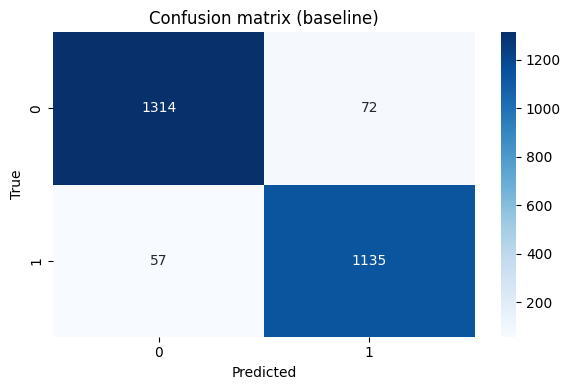

In [35]:
model_report(best_model, 'HP Search')

In [36]:
tuner.results_summary()

Results summary
Results in tuner_results/cnn_deepfakes
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 10 summary
Hyperparameters:
num_blocks: 3
use_global_avg_pooling: False
learning_rate: 0.0001
Score: 0.8262218832969666

Trial 03 summary
Hyperparameters:
num_blocks: 5
use_global_avg_pooling: True
learning_rate: 0.0001
Score: 0.8188518285751343

Trial 24 summary
Hyperparameters:
num_blocks: 3
use_global_avg_pooling: True
learning_rate: 0.0001
Score: 0.8079906702041626

Trial 02 summary
Hyperparameters:
num_blocks: 3
use_global_avg_pooling: True
learning_rate: 0.0005
Score: 0.7897595167160034

Trial 01 summary
Hyperparameters:
num_blocks: 2
use_global_avg_pooling: False
learning_rate: 0.0001
Score: 0.786268413066864

Trial 25 summary
Hyperparameters:
num_blocks: 5
use_global_avg_pooling: False
learning_rate: 0.0001
Score: 0.7839410305023193

Trial 23 summary
Hyperparameters:
num_blocks: 4
use_global_avg_pooling: False
learning_rate: 0.0001
Score: 0.776183

# Results and Analysis

<mark>NOTE: Result values in confusion matrices may be different than those referenced in the narrative text.</mark>

**Although we are setting an explicit random seed for all of the libraries in use, the training and inference results will still be nondeterministic due to our use of GPUs.**

## Summary of Scores

| Model                        | `Fake` Precision | `Fake` Recall | `Fake` F1 Score | Parameters (approx.) |
|------------------------------|------------------|---------------|-----------------|----------------------|
| Baseline (2 Layers)          | **0.9524** 🥇    | 0.8225        | 0.8827   | ~328k                |
| Baseline (4 Layers)          | 0.8544           | 0.6097        | 0.7116          | ~1.2M                |
| HP Search                    | 0.9283           | **0.9531** 🥇  | **0.9405** 🥇    | ~420k                |

The small model produced the best `Fake` precision results, while the model found from the Hyperparameter Search had the highest `Fake` recall and F1-score, indicating the **HP Search** model had the best balance in performance as far as precision and recall for `Fake` face images. The number of blocks/layers for the best model was 3, and the size (# parameters) was smaller than the large 4-layer model by about a third, and only ~100k larger than the 2-layer baseline.

## Hyperparameter Tuning Summary

The variable tuning parameters we used for the Hyperparameter Search were:

* Number of convolutional blocks, with each consisting of Conv2D, BatchNorm, Conv2D, BatchNorm, MaxPool2D.
* Whether or not to use `GlobalAveragePooling2D` vs. `Flatten` just before the final fully-connected `Dense` layer.
* Learning rate.

As mentioned previously, the hyperparameters for the best model were:

```
Num Conv Blocks: 3
Use Global Avg Pooling: False
Learning Rate: 0.0001
```

A medium sized network with 3 convolutional blocks was found to have the best performance, combined with a smaller learning rate (compared to our manually create/trained networks of 2 and 4 blocks) of 0.0001. Although I had expected `GlobalAveragePooling2D` to result in better performance by summarizing the final filter outputs into single values, the search results indicated that continuing to use `Flatten` for this case produced better results. This may be due to the problem domain requiring more fine-grained signals to help determine Real vs. Fake by picking up very small anomalies in the fake face images.

## Troubleshooting

One issue I found with using the TensorFlow `Dataset` combined with a single datasource (i.e., not already split into train/test sets) was that it was not immediately clear how to easily have train + validation + test sets. I ultimately settled on creating a pseudo-test set based on a random generation of a combined 20% from the original dataset under the assumption that the resulting test set should be a combination of train + validation images.

# Conclusion

## Results Summary

In summary, the best performing model was found to be the **HP Search** model. The final architecture was 3 levels of convolutional blocks, each consisting of `Conv2D`, `BatchNorm`, `Conv2D`, `BatchNorm`, and `MaxPool2D` layers. Using `Flatten` as the final layer before the fully-connected `Dense` layer contributed to the best resuts, likely by keeping fine-grained signals for the sigmoid function. Finally, the smaller learning rate of `0.0001` performed well by helping the **HP Search** model avoid too much instability during training.

## Learning and Takeaways

One nice lesson from this project is demonstrating concretely that larger networks are not automatically better when dealing with relatively complex tasks. In our case, the medium-small network (out of those tested) performed best relative to the largest in terms of convolutional "blocks". Additionally, we assumed that `GlobalAveragePooling2D` would produce better results than `Flatten` by summarizing the final filters, but `Flatten` actually resulted in the better performance. Both of these point to the fact that simpler/smaller models should still be considered for most tasks, especially when training and/or inference economy (with respect to CPU/GPU cycles) is a deciding factor.

Another point to consider is the use of the model. For example, if our goal is to miss the fewest `Fake` face images, we'd prefer the network with better recall score for `Fake`s.

## Challenges

The primary challenges with this project was centered around lack of enough GPU resources, leading to longer iteration times when troubleshooting errors or adding more models to the project. Ultimately, this led to the overall project taking much more wallclock time than originally anticipated.

Secondarily, the use of GPUs resulted in nondeterministic results between notebook executions, which sometimes caused the best performing model architecture to change. This was called out a few times in the notebook to ensure the reader understood that results output from code would likely be different than those referenced in the narrative text.

## Future Improvements

Due to time and resource limitations, this project only scratched the surface in the deepfake problem space. Future improvements and areas for exploration could include:

* Larger search space when using the Keras `RandomSearch` functionality to surface even more potential performance improvements.
* Experiment with slightly more complex architectures, such as adding skip-connections between blocks to retain some features discovered from earlier layers.
* Experiment with GANs for training, but in this case use the `discriminator` as the resulting model to test and use for real vs. fake classification.

# References
* https://www.geeksforgeeks.org/machine-learning/introduction-convolution-neural-network/
* https://keras.io/examples/vision/image_classification_from_scratch/
* https://www.coursera.org/learn/introduction-to-deep-learning-boulder
* https://www.tensorflow.org/tutorials/images/cnn
* https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/
* https://www.geeksforgeeks.org/deep-learning/what-is-batch-normalization-in-deep-learning/
* https://www.tensorflow.org/guide/data_performance